# Librairies utiles

In [1]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format

# Fonctions utiles

In [2]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Lignes:", df.shape[0])
    print("\nNombre de variables:", df.shape[1])
    print("\nVariables:")
    print(df.columns.tolist())
    print("\nvaleurs manquantes:", df.isnull().sum().values.sum())
    print("\nType de données:")
    print(df.dtypes)
    print("\nValeurs uniques:")
    print(df.nunique())

# Lecture des données

In [3]:
df = pd.read_excel('online_retail_II.xlsx')

In [4]:
dataoveriew(df , 'Vision globale des données')

Vision globale des données:

Lignes: 525461

Nombre de variables: 8

Variables:
['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

valeurs manquantes: 110855

Type de données:
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

Valeurs uniques:
Invoice        28816
StockCode       4632
Description     4681
Quantity         825
InvoiceDate    25296
Price           1606
Customer ID     4383
Country           40
dtype: int64


In [5]:
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00      7       13,085  United Kingdom  
1 2009-12-01 07:45:00      7       13,085  United Kingdom  
2 2009-12-01 07:45:00      7       13,085  United Kingdom  
3 2009-12-01 07:45:00      2       13,085  United Kingdom  
4 2009-12-01 07:45:00      1       13,085  United Kingdom

In [6]:
df.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Les variables concernées par les variables manquantes sont: la description de l'article acheté et l'ID du client. Dans la suite nous allons construire un modèle qui calcule le  risque de churn du client. Nous allons aussi prédire le volume d'achat de chaque client et par la suite calculer la CLTV de tous les clients. Nous allons dans un premier temps supprimer les ligne dont le customer ID n'est pas identifié.

In [7]:
new_df = df[pd.notnull(df['Customer ID'])]
print(new_df.shape)
new_df.isna().sum()

(417534, 8)


Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [8]:
new_df.describe()

Quantity   Price  Customer ID
count   417,534 417,534      417,534
mean         13       4       15,361
std         101      71        1,681
min      -9,360       0       12,346
25%           2       1       13,983
50%           4       2       15,311
75%          12       4       16,799
max      19,152  25,111       18,287

Nous observons des quantités négatives, ce qui peut paraitre surprenant. Mais, ces quantités négatives correspondent à des retours de produits. Nous devons retirer ceux là car ils nous apportent pas de l'information sur la tâche que nous cherchons à resoudre. D'autre part Customer ID est considéré comme une variable numérique ce qui n'est pas le cas en réalité.

In [9]:
new_df = new_df.query("Quantity	 >0 and Price>0").reset_index()
new_df.drop([ 'index'], axis=1, inplace=True)

In [10]:
new_df.describe()

Quantity   Price  Customer ID
count   407,664 407,664      407,664
mean         14       3       15,369
std          97      35        1,680
min           1       0       12,346
25%           2       1       13,997
50%           5       2       15,321
75%          12       4       16,812
max      19,152  10,954       18,287

In [11]:
## normalisation des dates
new_df["InvoiceDate"] = pd.to_datetime(new_df["InvoiceDate"]).dt.date
## conversion de l'id en une variable catégorielle
new_df['Customer ID'] = new_df['Customer ID'].astype(object)
new_df.describe(include='object').T

count unique                                 top    freq
Invoice      407664  19213                              500356     270
StockCode    407664   4017                              85123A    3153
Description  407664   4444  WHITE HANGING HEART T-LIGHT HOLDER    3153
InvoiceDate  407664    307                          2010-11-21    3248
Customer ID 407,664  4,312                              14,911    5,57
Country      407664     37                      United Kingdom  370929

Notre jeu de données contient 4314 clients et 307 dates de facturation pendant l'horizon étudié (l'horizon d'étude est de Janvier 2019 à décembre 2020). Les variables Invoice numbers, stock code and description ne nous apportent pas de l'information pour ce que nous étudions. Nous allons donc les supprimer. La variable Country pourrait être utile pour faire de la segmentation par pays. Cependant l'horizon d'étude n'étant pas très élévé nous ne pouvons par faire cette segmentation car un se retrouverai avec un volume de données très faible.

In [12]:
final_df = new_df.drop([ "StockCode", "Description", "Country"], axis=1 )


In [13]:
## calculons le revenu de chaque achat
final_df['Revenues'] = final_df['Quantity'] * final_df['Price']
final_df.head()

Invoice  Quantity InvoiceDate  Price Customer ID  Revenues
0  489434        12  2009-12-01      7      13,085        83
1  489434        12  2009-12-01      7      13,085        81
2  489434        12  2009-12-01      7      13,085        81
3  489434        48  2009-12-01      2      13,085       101
4  489434        24  2009-12-01      1      13,085        30

In [14]:
final_df.describe()

Quantity   Price  Revenues
count   407,664 407,664   407,664
mean         14       3        22
std          97      35        77
min           1       0         0
25%           2       1         5
50%           5       2        12
75%          12       4        20
max      19,152  10,954    15,818

# Le modèle RFM pour calculer la CLTV: Récence, fréquence et valeur monétaire (Recency, Frequency, and Monetary Value)

Le concept RFM repose sur l'axiome selon lequel les clients qui ont passé une commande plus récemment, qui ont acheté plus fréquemment et qui ont tendance à dépenser plus lors de leurs transactions sont susceptibles de revenir et d'être les clients les plus précieux. Bien que cette classification semble évidente, le concept RFM fournit les éléments de base à partir desquels le modèle béta géométrique/négative binomiale (BG/NBD) peut dériver ses prédictions. BG/NBDajoute des hypothèses de distribution aux mesures RFM.
<br>Quelques définitions:
<ul>
<li><b> Récence </b>: le temps compris entre le premier achat du client et son dernier achat.</li>
<li><b>Fréquence</b>: la fréquence avec laquelle le client achète, hormis son premier achat. </li>
<li><b>Valeur monétaire</b>: la valeur moyenne des transactions du client.</li>
<li><b>Age du client</b>: le temps écoulé entre une période de référence et son premier achat.</li>
</ul>
 </br>

 Le package Lifetimes calculera ces valeurs pour nous, mais faisons le calcul à la main pour un premier temps.


In [16]:
xmax_date = final_df["InvoiceDate"].max()

In [19]:
cltv = final_df.groupby('Customer ID').agg({
    'InvoiceDate': [
        lambda x: (x.max() - x.min()).days, #récence
        lambda x: (xmax_date - x.min()).days  #âge  
    ],
    'Invoice': lambda x: x.nunique()-1,  # fréquence
    'Revenues': lambda x: x.sum()  # valeur monétaire
})
cltv.columns = cltv.columns.droplevel(0)

cltv.columns = ['recency', 'T', 'frequency', 'monetary']

cltv = cltv[cltv['frequency'] > 0]
cltv['monetary'] = cltv['monetary'] / cltv['frequency']

In [21]:
ID = final_df['Customer ID'][507]
cltv.loc[ID,:]

recency     345
T           373
frequency    10
monetary    522
Name: 15998.0, dtype: float64

Utilisons le package sus cité pour répliquer ce calcul à tous nos clients.

In [22]:
t_holdout = 240 #Nombre de jours pour l'observation des clients                                        

max_date = final_df["InvoiceDate"].max()
print("Date maximale dans le jeu de données:", max_date)                   

max_cal_date = max_date - timedelta(days=t_holdout)  
print("Date de fin de calibration: ", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = final_df, 
        customer_id_col = "Customer ID", 
        datetime_col = "InvoiceDate",
        monetary_value_col = "Revenues", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  

print("Résultats:")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

Date maximale dans le jeu de données: 2010-12-09
Date de fin de calibration:  2010-04-13
customer behavior in calibration and holdout periods


frequency_cal  recency_cal  T_cal  monetary_value_cal  \
Customer ID                                                          
12,346                   5           78    120                  28   
12,358                   0            0    126                   0   
12,359                   3          108    129                 254   
12,360                   1           30     50                  40   
12,361                   0            0     77                   0   
...                    ...          ...    ...                 ...   
18,275                   0            0    126                   0   
18,276                   0            0    124                   0   
18,283                   2           37     53                 127   
18,285                   0            0     55                   0   
18,286                   0            0    118                   0   

             frequency_holdout  monetary_value_holdout  duration_holdout  
Customer ID                                                               
12,346                       1                       7               240  
12,358                       2                      31               240  
12,359                       2                      20               240  
12,360                       3                      19               240  
12,361                       2                      18               240  
...                        ...                     ...               ...  
18,275                       1                      37               240  
18,276                       4                      17               240  
18,283                       2                       3               240  
18,285                       0                       0               240  
18,286                       1                      17               240  

[2264 rows x 7 columns]

In [63]:
df_ch.describe()

frequency_cal  recency_cal  T_cal  monetary_value_cal  \
count          2,264        2,264  2,264               2,264   
mean               1           33     83                 196   
std                3           44     43                 455   
min                0            0      0                   0   
25%                0            0     46                   0   
50%                0            0     84                   0   
75%                1           72    125                 285   
max               49          133    133               8,416   

       frequency_holdout  monetary_value_holdout  duration_holdout  
count              2,264                   2,264             2,264  
mean                   3                      31               240  
std                    5                     162                 0  
min                    0                       0               240  
25%                    1                       5               240  
50%                    2                      16               240  
75%                    4                      24               240  
max                   94                   6,619               240

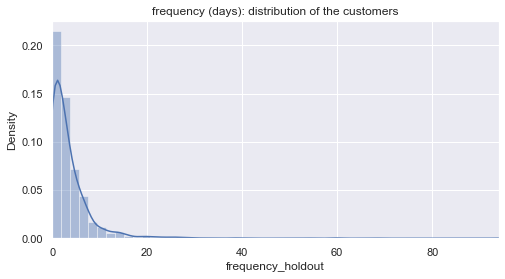

In [24]:

max_freq = df_ch["frequency_holdout"].max()




fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["frequency_holdout"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");


Text(0.5, 1.0, 'customer age T (days): distribution of the customers')

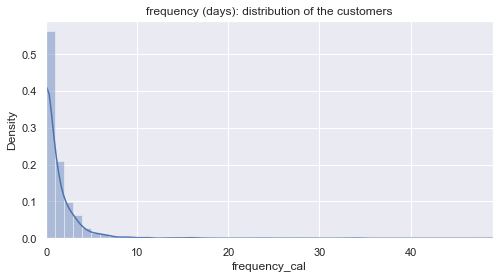

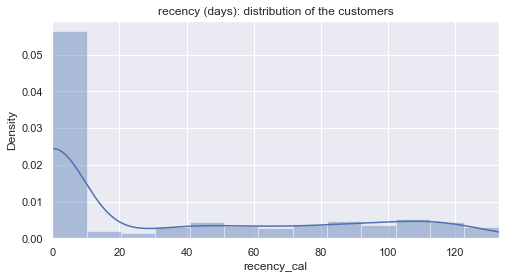

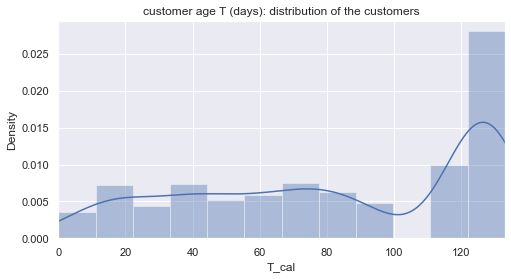

In [23]:

max_freq = df_ch["frequency_cal"].max()
max_rec = df_ch["recency_cal"].max()
max_T = df_ch["T_cal"].max()



fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");


fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers")



fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers")


<p>Au niveau de la récence on remarque beaucoup de clients sont des achéteurs ponctuels. C'est la raison pour laquelle nous avons le PIC à 0 jours.</p>

<p>L'âge du client T représente le nombre de jours écoulés depuis la "naissance" de l'acheteur, son premier jour en tant que nouveau client de l'entreprise et s'étend jusqu'à la fin de l'ensemble de données. La plupart des clients sont arrivés à bord 120 jours ou plus auparavant. Sur son horizon court de 4 mois, le graphique montre un niveau assez homogène de nouveaux clients ayant effectué leur premier achat il y a 20, 40, 60 ou 80 jours. Le graphique suggère que l'entreprise ne se trouve pas dans une tendance à la baisse. Elle a attiré de nouveaux clients à un taux stable sur un horizon de 120 jours.</p>

## Le modèle BG/NBD

Généralement, le comportement d'achat des clients ne suit pas une loi déterministe. LE niveau de demande et le taux de churn sont des variables aléatoires. Le modèle BG/NBD décrit les processus aléatoires qui influencent le comportement des clients, individuellement et globalement.
<br> Cette modélisation repose sur 4 hypothèses principales:
<ul>
<li><b> Le nombre de commandes d'un client </b> durant une période données suit une <b> Distribution de Poisson</b> de paramètre lambda . Ceci est équivalent à dire que le temps entre les transactions du clients suit une distribution exponentielle avec le même taux de transsaction lambda.</li>
<li>La demande varie indépendamment entre les clients : hétérogénéité en lambda. La variation de lambda est une variable aléatoire qui suit une distribution Gamma avec un paramètre de forme r et une échelle béta. </li>
<li>Après tout achat, un client peut devenir inactif avec une probabilité p et se détourner de l'entreprise. Le risque de churn suit une distribution géométrique.</li>
<li>Le risque de churn varie indépendamment entre les clients : hétérogénéité de p. La variation de la probabilité de churn p est une variable aléatoire qui suit une distribution Bêta.</li>
</ul>
 </br>

In [25]:
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)

Optimization terminated successfully.
         Current function value: 0.016980
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51


<lifetimes.BetaGeoFitter: fitted with 2264 subjects, a: 0.00, alpha: 57.42, b: 0.03, r: 0.76>

In [26]:
bgf.summary

coef  se(coef)  lower 95% bound  upper 95% bound
r         1         0                1                1
alpha    57         4               50               65
a         0         0               -0                0
b         0        11              -21               21

<Figure size 864x864 with 0 Axes>

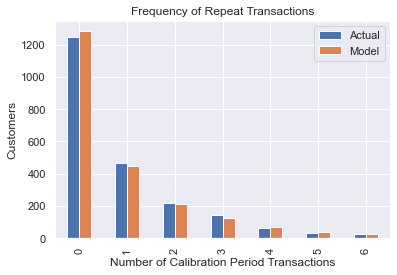

In [27]:
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

La méthode plot_period_transactions dessine un graphique qui compare les prédictions avec les observations réelles dans l'ensemble de données d'entraînement. La précision des prédictions semble assez bonne.

La méthode de Lifetimes plot_calibration_purchases_vs_holdout_purchases compare la fréquence prédite avec les achats réels dans la période de test.

<Figure size 504x504 with 0 Axes>

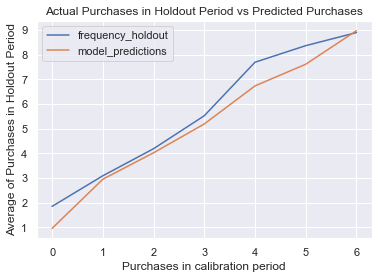

In [28]:
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);

## Jeu de données entier

In [29]:
df_rft = summary_data_from_transaction_data(
    transactions = final_df, 
    customer_id_col = "Customer ID", 
    datetime_col = "InvoiceDate", 
    monetary_value_col = "Revenues", 
    observation_period_end = max_date, 
    freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft

frequency  recency   T  monetary_value
Customer ID                                        
12,346               6      196 360              47
12,347               1       37  39             712
12,348               0        0  73               0
12,349               2      182 224             801
12,351               0        0  10               0
...                ...      ...  ..             ...
18,283               4      276 293             135
18,284               0        0  66               0
18,285               0        0 295               0
18,286               1      247 358             833
18,287               2      189 206             637

[4312 rows x 4 columns]

12346.0

In [30]:
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -2.794653
         Iterations: 36
         Function evaluations: 37
         Gradient evaluations: 37


coef  se(coef)  lower 95% bound  upper 95% bound
r      0.875     0.028            0.819            0.931
alpha 71.449     2.701           66.155           76.742
a      0.020     0.017           -0.013            0.054
b      9.207     6.812           -4.143           22.558

127


<Figure size 864x864 with 0 Axes>

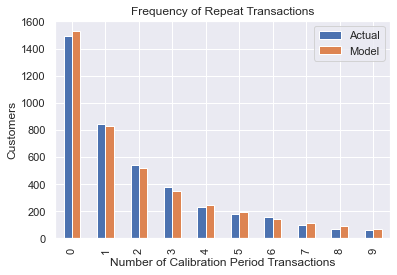

In [31]:
#longueur des axes
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))          
max_T = int(df_rft["T"].max())                         
max_rec = int(df_rft["recency"].max())  
print(max_freq)



fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10);

Cette matrrice permet de visualiser le nombre espéré d'achats des clients en fonction de leur fréquence d'achat et la récence sur des périodes de 10 à 90 jours.

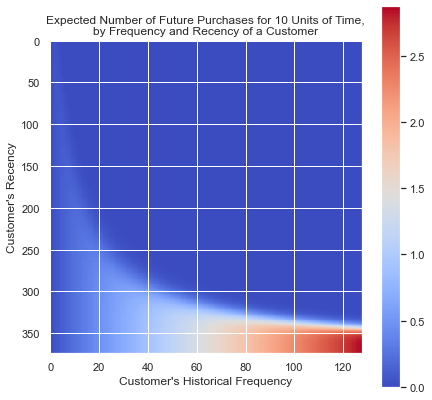

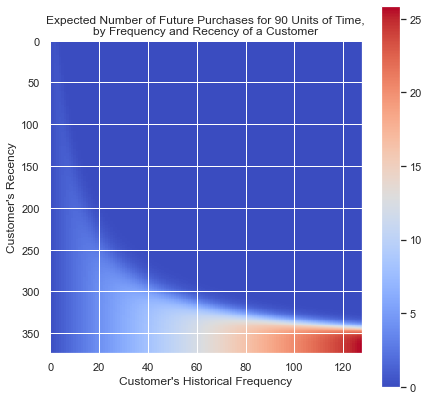

In [32]:
def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,  
            max_frequency = max_freq,  
            max_recency = max_rec);
            
            

tFC = [10, 90]
_ = [plot_freq_rec(t) for t in tFC]

<p>Les matrices de fréquence/récence montrent toutes deux la même forme de la distribution de probabilité, pour 10 comme pour 90 jours. La forme de la distribution reste constante. Elles ne diffèrent que par leurs échelles sur le côté droit : le nombre d'achats sur un nombre de jours plus ou moins long.</p>

<p> Chaque matrice montre qu'un client ayant une fréquence élevée (80 transactions ou plus), associée à une longue récence (plus de 300 jours entre la première et la dernière transaction), présentera la plus forte propension aux achats futurs : de l'orange au rouge, ce qui implique 15 à 25 transactions au cours des 90 prochains jours.</p>

In [33]:
t = 30
custID = 12748

df_rft_C = df_rft.loc[custID,:]
predC = bgf.predict(    t, 
                        df_rft_C["frequency"], 
                        df_rft_C["recency"], 
                        df_rft_C["T"])
print("Client", custID, ": le nombre espéré d'achat dans ", t, "jours =", f'{predC:.1f}')

Client 12748 : le nombre espéré d'achat dans  30 jours = 6.5


In [34]:
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])
                    

t_FC = [10, 30, 60, 90]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("prédiction du nombre d'achat pour chaque clients dans les t prochains jours:")
df_rft

prédiction du nombre d'achat pour chaque clients dans les t prochains jours:


frequency  recency     T  monetary_value  predict_purch_10  \
Customer ID                                                               
12,346.0           6.0    196.0 360.0            47.1               0.2   
12,347.0           1.0     37.0  39.0           711.8               0.2   
12,348.0           0.0      0.0  73.0             0.0               0.1   
12,349.0           2.0    182.0 224.0           801.3               0.1   
12,351.0           0.0      0.0  10.0             0.0               0.1   
...                ...      ...   ...             ...               ...   
18,283.0           4.0    276.0 293.0           135.1               0.1   
18,284.0           0.0      0.0  66.0             0.0               0.1   
18,285.0           0.0      0.0 295.0             0.0               0.0   
18,286.0           1.0    247.0 358.0           833.5               0.0   
18,287.0           2.0    189.0 206.0           637.0               0.1   

             predict_purch_30  predict_purch_60  predict_purch_90  
Customer ID                                                        
12,346.0                  0.5               0.9               1.4  
12,347.0                  0.5               1.0               1.5  
12,348.0                  0.2               0.4               0.5  
12,349.0                  0.3               0.6               0.9  
12,351.0                  0.3               0.6               1.0  
...                       ...               ...               ...  
18,283.0                  0.4               0.8               1.2  
18,284.0                  0.2               0.4               0.6  
18,285.0                  0.1               0.1               0.2  
18,286.0                  0.1               0.3               0.4  
18,287.0                  0.3               0.6               0.9  

[4312 rows x 8 columns]

Avec ces prédictions nous pouvons par exemple afficher les 10 meilleurs clients dans les 30 prochains jours.

In [35]:

print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


frequency  recency     T  monetary_value  predict_purch_10  \
Customer ID                                                               
14,911.0         127.0    373.0 373.0         1,192.2               2.9   
15,311.0         109.0    373.0 373.0           506.2               2.5   
12,748.0          95.0    370.0 370.0           238.5               2.2   
14,606.0          94.0    370.0 371.0           196.7               2.1   
17,841.0          84.0    372.0 372.0           349.5               1.9   
14,156.0          78.0    367.0 373.0         2,506.4               1.8   
14,527.0          68.0    372.0 372.0           270.0               1.6   
13,089.0          67.0    369.0 372.0           858.9               1.5   
17,377.0          50.0    372.0 372.0           263.3               1.1   
17,961.0          49.0    366.0 373.0            34.6               1.1   

             predict_purch_30  predict_purch_60  predict_purch_90  
Customer ID                                                        
14,911.0                  8.6              17.2              25.8  
15,311.0                  7.4              14.8              22.2  
12,748.0                  6.5              13.0              19.5  
14,606.0                  6.4              12.8              19.3  
17,841.0                  5.7              11.5              17.2  
14,156.0                  5.3              10.6              15.9  
14,527.0                  4.7               9.3              13.9  
13,089.0                  4.6               9.2              13.7  
17,377.0                  3.4               6.9              10.3  
17,961.0                  3.4               6.7              10.1

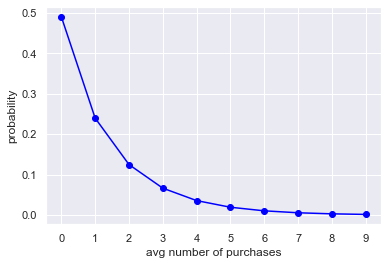

In [36]:

def prob_purch(t, n):
    p = bgf.probability_of_n_purchases_up_to_time(t, n)
    return p
    
    
    

t = 90                
purch = range(0,10,1)   
probs = [prob_purch(t,n) for n in purch]

dict_probs = dict(zip(purch, probs))


plt.plot(purch, probs, '-o', color='blue')
plt.xlabel("avg number of purchases")
plt.ylabel("probability")
plt.xticks(purch)
plt.show()

## Probabilité de Churn

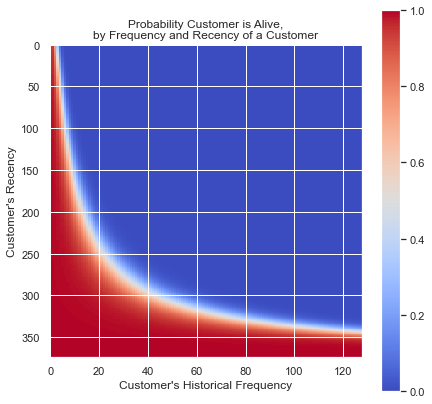

In [37]:
fig = plt.figure(figsize=(7, 7)) 
plot_probability_alive_matrix(
            model = bgf,  
            max_frequency = max_freq,  
            max_recency = max_rec);

In [38]:
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"])

df_rft["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rft.describe()

frequency  recency        T  monetary_value  predict_purch_10  \
count   4,312.00 4,312.00 4,312.00        4,312.00          4,312.00   
mean        2.94   134.32   224.50          271.48              0.12   
std         6.02   133.00   118.91          416.19              0.14   
min         0.00     0.00     0.00            0.00              0.02   
25%         0.00     0.00   116.00            0.00              0.05   
50%         1.00   105.50   252.00          190.07              0.09   
75%         3.00   254.00   328.00          370.36              0.14   
max       127.00   373.00   373.00        8,416.40              2.88   

       predict_purch_30  predict_purch_60  predict_purch_90  prob_alive  
count          4,312.00          4,312.00          4,312.00    4,312.00  
mean               0.36              0.73              1.09        1.00  
std                0.42              0.84              1.26        0.03  
min                0.06              0.12              0.18        0.21  
25%                0.16              0.32              0.48        1.00  
50%                0.26              0.52              0.78        1.00  
75%                0.43              0.87              1.30        1.00  
max                8.62             17.24             25.84        1.00

In [39]:
df_rft[df_rft["prob_alive"]<0.9]

frequency  recency      T  monetary_value  predict_purch_10  \
Customer ID                                                                
12,482.00         5.00    77.00 288.00        3,450.73              0.13   
12,835.00        36.00   309.00 371.00          159.95              0.74   
13,413.00         3.00    48.00 322.00          137.32              0.08   
13,902.00         4.00    92.00 359.00        8,416.40              0.10   
14,160.00         6.00    88.00 333.00          794.51              0.09   
15,359.00         3.00    31.00 328.00           58.08              0.07   
15,413.00         4.00    47.00 373.00        1,557.12              0.05   
15,607.00         7.00   157.00 335.00          177.21              0.17   
15,633.00        12.00   222.00 366.00          346.71              0.25   
15,768.00        29.00   260.00 371.00          499.15              0.17   
15,911.00         6.00   107.00 365.00          239.18              0.09   
17,230.00         9.00   168.00 366.00          664.70              0.15   
17,448.00        17.00   148.00 280.00          830.90              0.11   
17,969.00        17.00   231.00 368.00          120.02              0.25   
18,051.00         6.00    96.00 365.00          324.83              0.08   

             predict_purch_30  predict_purch_60  predict_purch_90  prob_alive  
Customer ID                                                                    
12,482.00                0.38              0.77              1.15        0.78  
12,835.00                2.23              4.45              6.68        0.89  
13,413.00                0.25              0.50              0.75        0.84  
13,902.00                0.29              0.57              0.86        0.84  
14,160.00                0.27              0.55              0.82        0.54  
15,359.00                0.21              0.43              0.64        0.74  
15,413.00                0.16              0.32              0.48        0.49  
15,607.00                0.52              1.03              1.55        0.89  
15,633.00                0.75              1.50              2.26        0.85  
15,768.00                0.50              0.99              1.49        0.25  
15,911.00                0.28              0.56              0.85        0.60  
17,230.00                0.46              0.93              1.39        0.69  
17,448.00                0.33              0.65              0.98        0.21  
17,969.00                0.74              1.48              2.22        0.61  
18,051.00                0.23              0.46              0.69        0.49

## CLTV

In [40]:
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

frequency  recency        T  monetary_value  predict_purch_10  \
count   2,818.00 2,818.00 2,818.00        2,818.00          2,818.00   
mean        4.50   205.54   263.85          415.41              0.16   
std         6.96   111.48   101.38          453.07              0.16   
min         1.00     1.00     6.00            7.90              0.04   
25%         1.00   113.00   199.00          196.47              0.08   
50%         3.00   214.00   289.00          311.66              0.12   
75%         5.00   304.00   359.00          473.96              0.18   
max       127.00   373.00   373.00        8,416.40              2.88   

       predict_purch_30  predict_purch_60  predict_purch_90  prob_alive  
count          2,818.00          2,818.00          2,818.00    2,818.00  
mean               0.47              0.94              1.41        0.99  
std                0.48              0.96              1.44        0.03  
min                0.12              0.24              0.36        0.21  
25%                0.23              0.45              0.68        1.00  
50%                0.36              0.71              1.07        1.00  
75%                0.55              1.10              1.65        1.00  
max                8.62             17.24             25.84        1.00

Une des hypothèses du modèle est l'indépendance entre la fréquence d'achat et la valeur monétaire. Nous allons calculer cette corrélation. Dans la cellule ci dessous la corrélation est assez faible entre les deux.

In [41]:
corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.187


In [42]:
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

coef  se(coef)  lower 95% bound  upper 95% bound
p   4.634     0.217            4.208            5.060
q   2.508     0.072            2.367            2.650
v 145.096     8.423          128.586          161.605

In [43]:

exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]

mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.11


frequency  recency       T  monetary_value  predict_purch_10  \
Customer ID                                                                 
12,346.000       6.000  196.000 360.000          47.143             0.153   
12,347.000       1.000   37.000  39.000         711.790             0.169   
12,349.000       2.000  182.000 224.000         801.310             0.097   
12,352.000       1.000   17.000  27.000         200.050             0.190   
12,356.000       2.000   44.000  59.000       1,325.905             0.220   

             predict_purch_30  predict_purch_60  predict_purch_90  prob_alive  \
Customer ID                                                                     
12,346.000              0.460             0.920             1.379       0.963   
12,347.000              0.508             1.015             1.521       0.998   
12,349.000              0.291             0.582             0.872       0.997   
12,352.000              0.569             1.138             1.705       0.997   
12,356.000              0.659             1.317             1.973       0.997   

             exp_avg_rev   avg_rev  error_rev  
Customer ID                                    
12,346.000        67.655    47.143     20.512  
12,347.000       646.449   711.790    -65.341  
12,349.000       751.536   801.310    -49.774  
12,352.000       260.384   200.050     60.334  
12,356.000     1,202.698 1,325.905   -123.207

In [44]:
DISCOUNT_a = 0.06               
LIFE = 12                      

discount_m = (1 + DISCOUNT_a)**(1/12) - 1    

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_rftv["frequency"],  
        recency = df_rftv["recency"],  
        T = df_rftv["T"],  
        monetary_value = df_rftv["monetary_value"],  
        time = LIFE,    
        freq = "D",                          
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             
df_rftv.describe().T

count      mean       std      min     25%       50%  \
CLV              2,818.000 2,698.504 8,552.677  169.767 795.710 1,400.017   
frequency        2,818.000     4.502     6.959    1.000   1.000     3.000   
recency          2,818.000   205.538   111.476    1.000 113.000   214.000   
T                2,818.000   263.854   101.380    6.000 199.000   289.000   
monetary_value   2,818.000   415.410   453.070    7.900 196.471   311.660   
predict_purch_10 2,818.000     0.157     0.160    0.040   0.076     0.119   
predict_purch_30 2,818.000     0.472     0.480    0.119   0.227     0.356   
predict_purch_60 2,818.000     0.944     0.960    0.238   0.455     0.712   
predict_purch_90 2,818.000     1.415     1.439    0.357   0.682     1.067   
prob_alive       2,818.000     0.993     0.031    0.214   0.995     0.997   
exp_avg_rev      2,818.000   424.235   411.872   30.106 232.886   332.420   
avg_rev          2,818.000   415.410   453.070    7.900 196.471   311.660   
error_rev        2,818.000     8.825    57.166 -875.343  -1.503    10.586   

                       75%         max  
CLV              2,499.206 274,217.659  
frequency            5.000     127.000  
recency            304.000     373.000  
T                  359.000     373.000  
monetary_value     473.963   8,416.400  
predict_purch_10     0.183       2.876  
predict_purch_30     0.550       8.625  
predict_purch_60     1.099      17.239  
predict_purch_90     1.647      25.843  
prob_alive           0.998       1.000  
exp_avg_rev        470.741   8,198.911  
avg_rev            473.963   8,416.400  
error_rev           32.502     107.523